## Python Code Notebook for Evaluating and Comparing Code Generation Quality

In [1]:
# installations

! pip install -U langchain-openai
! pip install python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13


In [2]:
import warnings

warnings.filterwarnings("ignore")

from transformers import pipeline
import matplotlib.pyplot as plt
import numpy as np
import openai
import json
import re
import os

In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [5]:
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

In [6]:
# Check if the API key is loaded correctly (optional)
print("API Key loaded:", bool(api_key))

API Key loaded: True


## List of Models from Huggingfac to be Evaluated

In [7]:
# we are testing small models here.

models = [
    "Salesforce/codegen-350M-mono",
    "HuggingFaceTB/SmolLM-360M",
    "EleutherAI/gpt-neo-125m"
]

In [8]:
# Create the Prompt Template
# temperature can be between 0 and 2. 0 means the generation is absolutely fact based.
# Higher is the temperature, more creative is the LLM.

model = ChatOpenAI(model_name="gpt-4o", temperature=0)

In [9]:
# Define a code generation problem for Testing our Evaluation Framework
problem_statement = "Write a Python code that finds the longest word in a sentence."

# Code Evaluation donbe by making API Caals to OPpen AI GPT

In [10]:
# Function to evaluate generated code using OpenAI GPT API

def evaluate_code(question, code):
    promptstr = '''
    You are a cde reviewer who evaluates a given Python Code against a given Problem.
    The coding problem is as follows: {problem}
    Evaluate the following Python code for correctness and quality against the given problem: {pythoncode}.
    Provide scores on a scale of 1 to 5 for the following criteria:
    1. Correctness: How correct is the code in terms of logic and output against the given problem?
    2. Efficiency: How efficient is the solution in terms of execution?
    3. Readability: How readable and well-structured is the code?
    4. Best Practices: How well does the code follow coding best practices?
    5. Comments: How well are the code and logic explained with comments?
    Return only a JSON object with the criteria and the scores enclosed in with ```json tag and nothing else.
    '''
    prompt = ChatPromptTemplate.from_template(promptstr)
    chain = prompt | model
    response = chain.invoke({"problem": question, "pythoncode": code}).content.strip()

    print("----------- GENERATED EVANUATION ------------------------------------")
    print(response)
    print("---------------------------------------------------------------------")

    # Extract the scores from the response
    scores = extract_json_from_evaluation(response)

    return scores

# Extract JSON Objet from response

In [11]:
def extract_json_from_evaluation(evaluation_text):
    """
    Extracts the JSON object from the given evauation text.

    Parameters
    evaluation_text (str): The text containing the evaluation, including the JSON object.

    Returns:
    dict: The extracted JSON object as a dictionary.
    """
    # Use regular expression to find the JSON object within a text
    match = re.search(r'```json\n(.*?)\n```', evaluation_text, re.DOTALL)
    if match:
        json_str = match.group(1)
        try:
            # Parse the JSON string into a dictionary
            json_data = json.loads(json_str)
            return json_data
        except json.JSONDecodeError:
            print("Error: Failed to decode JSON.")
            return None
    else:
        print("Error: No JSON object found in the text.")
        return None

# Visualize The Evaluation Parameters

In [16]:
# Extract the criteria and scores for visualization

def visualize_scores(evaluation_results):
    criteria = list(evaluation_results[0]['Scores'].keys())
    num_criteria = len(criteria)
    num_models = len(evaluation_results)
    bar_width = 0.2

    # Generate a color map for different models
    colors = plt.cm.viridis(np.linspace(0, 1, num_models))

    # Set up the bar chart
    fig, ax = plt.subplots(figsize=(12, 6))  # Use plt.subplots instead of plt.subplot

    # Generate bars for each model
    for i, result in enumerate(evaluation_results):
        model_scores = list(result['Scores'].values())  # Fix 'Score' to 'Scores' to match dictionary key
        bar_positions = np.arange(num_criteria) + bar_width * i
        ax.bar(bar_positions, model_scores, bar_width, label=f'Model {i + 1}', color=colors[i])

    # Set chart labels and title
    ax.set_xlabel('Evaluation Criteria')
    ax.set_ylabel('Scores')
    ax.set_title('Evaluation Scores for Code Generation Models')
    ax.set_xticks(np.arange(num_criteria) + bar_width * (num_models / 2 - 0.5))
    ax.set_xticklabels(criteria)
    ax.legend()

    # Display the chart
    plt.tight_layout()
    plt.show()


# Generate the Code and call functions for Evaluation

In [13]:
# Iterate over models, generate code, and evaluate
results = []

for model_name in models:

    print("--------------------------------------------------------------------")
    print("Evaluating Model: ", model_name)
    print("--------------------------------------------------------------------")

    # Load the pipeline
    generator = pipeline("text-generation", model=model_name, device=0)

    # Generate code
    generated_code = generator(problem_statement, max_length=200, truncation=True)[0]['generated_text']

    print("--------------------------------------------------------------------")
    print("Generated Code: '\n", generated_code)
    print("--------------------------------------------------------------------")

    # Evaluate code
    evaluation_scores = evaluate_code(problem_statement, generated_code)

    # Append the result
    results.append({
        "Scores": evaluation_scores
    })

--------------------------------------------------------------------
Evaluating Model:  Salesforce/codegen-350M-mono
--------------------------------------------------------------------


config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/797M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


--------------------------------------------------------------------
Generated Code: '
 Write a Python code that finds the longest word in a sentence.\n"
        "\n"
        "Longest word:")
    try:
        while True:
            myword = read_word()
            if is_word(myword) == True:
                print_word(myword)
                # if myword == "":
            else:
                print_word_line("error: wrong input - wrong word type - try again")
                # else:
                #     print_word_line("error: wrong input - wrong word type - try again\n")
            break

    except:
        print_word_line("error: wrong input - wrong word type - try again")


def print_string():
    print("-" * 48)
    print("    string")
    print("-" * 48)


print("The word is: ")

--------------------------------------------------------------------
----------- GENERATED EVANUATION ------------------------------------
```json
{
    "Correctness": 1,
    "Efficiency": 1,
    "Re

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


--------------------------------------------------------------------
Generated Code: '
 Write a Python code that finds the longest word in a sentence.

# In[1]:


def longest_word(sentence):
    longest_word = ""
    for word in sentence.split():
        if len(word) > len(longest_word):
            longest_word = word
    return longest_word


# In[2]:


longest_word("Hello world!")


# In[3]:


longest_word("Hello world!")


# In[4]:


longest_word("Hello world!")


# In[5]:


longest_word("Hello world!")


# In[6]:


longest_word("Hello world!")


# In[7]:


longest_word("Hello world!")


# In[8]:


longest_word("Hello world!")


# In[9]:


longest_word
--------------------------------------------------------------------
----------- GENERATED EVANUATION ------------------------------------
```json
{
    "Correctness": 5,
    "Efficiency": 5,
    "Readability": 5,
    "Best Practices": 4,
    "Comments": 1
}
```
---------------------------------------------------------------------
--

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


--------------------------------------------------------------------
Generated Code: '
 Write a Python code that finds the longest word in a sentence.

I have a list of words that I want to find the longest word in a sentence. I want to find the longest word in a sentence that is longer than the longest word in the list.

A:

You can use the following code:
from itertools import chain

words = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l','m', 'n', 'o', 'p', 'q', 'r','s', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z',
--------------------------------------------------------------------
----------- GENERATED EVANUATION ------------------------------------
```json
{
    "Correctness": 1,
    "Efficiency": 1,
    "Readability": 1,
    "Best Practices": 1,
    "Comments": 1
}
```
---------------------------------------------------------------------


In [14]:
results

[{'Scores': {'Correctness': 1,
   'Efficiency': 1,
   'Readability': 1,
   'Best Practices': 1,
   'Comments': 1}},
 {'Scores': {'Correctness': 5,
   'Efficiency': 5,
   'Readability': 5,
   'Best Practices': 4,
   'Comments': 1}},
 {'Scores': {'Correctness': 1,
   'Efficiency': 1,
   'Readability': 1,
   'Best Practices': 1,
   'Comments': 1}}]

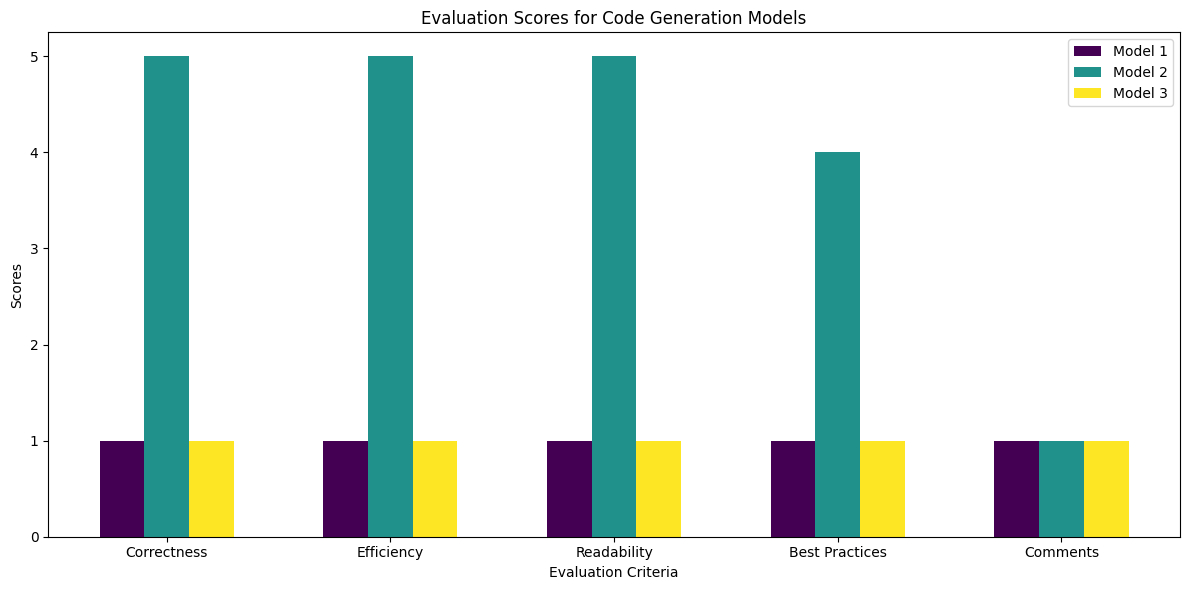

In [17]:
visualize_scores(results)

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM-360M"
device = "cuda" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# for multiple GPUs install accelerate and do `model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto")`
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
inputs = tokenizer.encode("def print_hello_world():", return_tensors="pt").to(device)
outputs = model.generate(inputs)
print(tokenizer.decode(outputs[0]))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


def print_hello_world():
    print("Hello World!")

# print_hello_
